Seems that small and faint clusters get biased towards the higher ICL fractions while brighter galaxies get biased towards the bottom. Plot cluster richness against total luminosity of the cluster and ICL fraction to see if there is a trend.

In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.io import ascii
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
import numpy as np
import h5py

cutouts = h5py.File('../cutouts_550.hdf')
zs = ascii.read('../../data/processed/camira_final.tbl')['z_cl']
cosmo = FlatLambdaCDM(H0=68.4, Om0=0.301)

In [2]:
from astropy.io import ascii
from astropy.table import join

# Load the cluster member catalogue
members = ascii.read('../../data/raw/camira_s20a_dud_member.dat', 
                     names=['RA_cl', 'Dec_cl', 'Richness', 'z_cl', 'RA', 'Dec', 'M', 'w'])

# Match this catalogue to the cluster catalogue
clusters = ascii.read('../../data/processed/camira_final.tbl')
merged = join(members, clusters, keys_left=['RA_cl', 'Dec_cl'], keys_right=['RA [deg]', 'Dec [deg]'])
merged = merged['ID', 'Name', 'RA_cl', 'Dec_cl', 'z_cl_1', 'RA', 'Dec']
merged

<Table length=6575>
  ID         Name         RA_cl      Dec_cl   z_cl_1     RA        Dec   
int64       str17        float64    float64  float64  float64    float64 
----- ----------------- ---------- --------- ------- ---------- ---------
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.907027  -4.66417
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.873273 -4.691256
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.928945 -4.684164
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.876194 -4.664761
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.904107 -4.679378
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.934757 -4.684694
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.880616 -4.669356
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.859355 -4.677844
    0 HSCJ021528-044041  33.867663 -4.678112   0.332   33.94297 -4.695663
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.864138 -4.674826
  ...               ...        ...       ...     ...        ...       ...
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.905278  0.245359
  124 HSCJ233534+001428 353.893629  0.241214   0.472  353.89281  0.246362
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.900678  0.228819
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.898396  0.253207
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.899637  0.247687
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.868137  0.225652
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.851071  0.214373
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.878795   0.26049
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.908142  0.247897
  124 HSCJ233534+001428 353.893629  0.241214   0.472  353.86774  0.241989

In [3]:
# Convenience function for plotting the images
stddev = 0.017359
def stretch(img):
    return np.arcsinh(np.clip(img, a_min=0.0, a_max=10.0) / stddev)

In [4]:
from photutils.background import Background2D
from scipy.interpolate import CloughTocher2DInterpolator

def background_estimate(cutout, mask=None, z=None, cosmo=None):
    """
    Returns an estimate of the 2D background of `cutout`. The background is 
    measured in boxes of size 50px around the edges of the image, and the
    background is interpolated over the entire image. 
    """
    box_size = cutout.shape[0] // 14
    
    # Run photutil's Background2D for the low resolution grid
    bkg_initial = Background2D(cutout, box_size=box_size, mask=mask)
    mesh = bkg_initial.background_mesh

    if cosmo is not None and z is None:
        return bkg_initial.background

    # Extract the edges of the mesh
    Y, X = np.ogrid[:mesh.shape[0], :mesh.shape[1]]
    y_cen, x_cen = (mesh.shape[0] // 2, mesh.shape[1] // 2) 

    box_cen = (box_size - 1) / 2.0

    if cosmo is not None:
        # Create a mask to cover the internal 350 kpc
        px_dist = cosmo.arcsec_per_kpc_proper(z) * 350 * 1/0.168
        size = int(np.ceil(px_dist.value / box_size))
        box = (X > x_cen - size) & (X < x_cen + size) & (Y > y_cen - size) & (Y < y_cen + size)
    else:
        # Get values from the edges of the cutout (basically for backwards compatibility with the old version)
        box = ~((X == 0) | (X == X.shape[1] - 1) | (Y == 0) | (Y == Y.shape[0] - 1))

    # Get values from the mesh corresponding to these coordinates
    vals = mesh[~box]

    # Array of coordinates in image units
    real_square = np.argwhere(~box) * box_size + box_cen

    # Interpolate over the centre of the square
    interp = CloughTocher2DInterpolator(real_square, vals)
    x = np.arange(np.min(real_square[:,0]), np.max(real_square[:,0]))
    y = np.arange(np.min(real_square[:,1]), np.max(real_square[:,1]))
    x, y = np.meshgrid(x, y) # 2D grid
    z = interp(x, y).T

    # Expand the image to the correct size
    edge_widths = (
        (int(np.abs(cutout.shape[0] - z.shape[0])/2), 
        int(np.ceil(np.abs(cutout.shape[0] - z.shape[0])/2))),
        (int(np.abs(cutout.shape[1] - z.shape[1])/2),
        int(np.ceil(np.abs(cutout.shape[1] - z.shape[1])/2)))
    )
    bkg = np.pad(z, pad_width=edge_widths, mode='reflect')

    # Return background estimation
    return bkg

def create_circular_mask(z, img, cosmo, radius_kpc=130):
    """
    Returns a circular mask of 130kpc radius for given `z` and given cosmology
    `cosmo` for image `img`.
    """
    # Calculate the radius in pixels
    arcsec_to_px = 1/0.168
    radius = (cosmo.arcsec_per_kpc_proper(z) * radius_kpc).value * arcsec_to_px
    
    # Generate the mask
    centre = (img.shape[1] // 2, img.shape[0] // 2)
    Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
    dist_from_centre = np.sqrt((X-centre[0])**2 + (Y-centre[1])**2)

    mask = dist_from_centre <= radius

    return mask

def counts2sb(counts, z):
    return 2.5 * np.log10(63095734448.0194 / counts) + 5 * np.log10(0.168) - 10 * np.log10(1+z)

def sb2counts(sb): # without reaccounting for dimming
    return 10**(-0.4*(sb - 2.5*np.log10(63095734448.0194) - 5.*np.log10(0.168)))

In [5]:
fracs = np.load('../../fracs.npy')
total_lum = fracs[1]
icl_frac = fracs[2]

tbl = ascii.read('../../data/processed/camira_final.tbl')
tbl = tbl[:125] # dud clusters only
richness = tbl['Richness']

# Take out the nans
total_lum = total_lum[~np.isnan(icl_frac)]
richness = richness[~np.isnan(icl_frac)]
icl_frac = icl_frac[~np.isnan(icl_frac)]

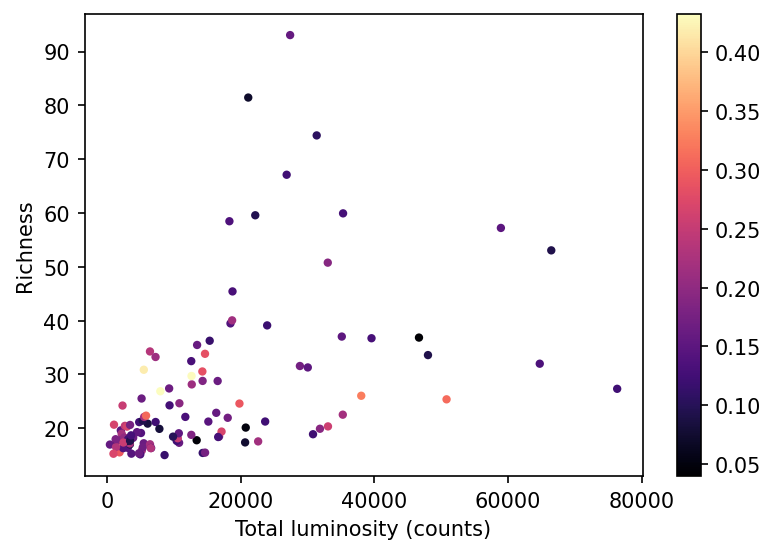

In [6]:
plt.figure(figsize=(6,4), dpi=150)
plt.scatter(total_lum, richness, marker='.', c=icl_frac, cmap='magma')
plt.xlabel('Total luminosity (counts)')
plt.ylabel('Richness')
plt.colorbar()
plt.show()

Try enlarging the ```circ_mask``` radius for clusters with high richness (just a basic step function for now)

In [7]:
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.table import Table
from photutils.segmentation import detect_threshold, detect_sources

def create_cold_labels(cutout: np.ndarray, bad_mask: np.ndarray, background: np.ndarray) -> np.ndarray:
    """
    Labels extended, bright sources in `cutout` with different integer values 
    for each source.
    """
    # First apply the bright star mask
    mask_input = np.array(cutout)
    mask_input[bad_mask] = np.nan

    # Smooth the image to help detect extended bright sources
    kernel = Gaussian2DKernel(5)
    kernel.normalize()
    convolved = convolve(mask_input, kernel)
    
    # Detect threshold
    threshold = detect_threshold(mask_input, nsigma=1.1, background=background, mask=bad_mask)

    # Detect sources
    segm = detect_sources(convolved, threshold=threshold, npixels=40)

    return segm.data

def enlarge_mask(labels: np.ndarray, sigma: float=1.) -> np.ndarray:
    """
    Convolves `labels` with a Gaussian kernel of sigma `sigma` and converts to 
    boolean type. This creates a mask where the sources have been dilated.
    """
    # Make the mask larger by convolving
    kernel = Gaussian2DKernel(sigma)
    mask = convolve(labels, kernel).astype(bool)

    return mask

def create_hot_labels(unsharp: np.ndarray, bad_mask: np.ndarray, background: np.ndarray) -> np.ndarray:
    """
    Labels small dim sources in `cutout` with different integer values for each 
    source.
    """
    # Detect threshold
    threshold = detect_threshold(unsharp, nsigma=1.2, background=background, mask=bad_mask)
    
    # Detect sources
    segm = detect_sources(unsharp, threshold, npixels=7, mask=bad_mask)

    return segm.data

def get_member_locs(idx: int, merged: Table, cutout_shape: tuple) -> tuple:
    """
    Returns pixel coordinates of cluster members as given by the RA and Dec 
    coordinates in `merged`.
    """
    # Get cluster location
    cluster_ra = merged[merged['ID'] == idx]['RA_cl'][0]
    cluster_dec = merged[merged['ID'] == idx]['Dec_cl'][0]
    centre_px = (cutout_shape[0] // 2, cutout_shape[1] // 2)

    # Get the cluster members
    c_members = merged[merged['ID'] == idx]
    ras = c_members['RA']
    decs = c_members['Dec']
    
    # Get offsets in degrees and convert to pixels
    ra_offsets = ras - cluster_ra
    dec_offsets = decs - cluster_dec
    x_offsets = ra_offsets * 3600 / 0.168
    y_offsets = dec_offsets * 3600 / 0.168

    # Get pixel locations
    centre = (cutout_shape[1] // 2, cutout_shape[0] // 2)
    x_locs_all = centre[0] - x_offsets # ra decreases from left to right
    y_locs_all = centre[1] + y_offsets
    x_locs = x_locs_all[(x_locs_all >= 0) & (x_locs_all < cutout_shape[1]) & (y_locs_all >= 0) & (y_locs_all < cutout_shape[0])]
    y_locs = y_locs_all[(x_locs_all >= 0) & (x_locs_all < cutout_shape[1]) & (y_locs_all >= 0) & (y_locs_all < cutout_shape[0])]
    
    return (x_locs, y_locs)

def create_member_mask(cutout: np.ndarray, bad_mask: np.ndarray, background: np.ndarray, z: float, cosmo: FlatLambdaCDM, merged: Table, idx: int) -> np.ndarray:
    # Cold masking
    cold_labels = create_cold_labels(cutout, bad_mask, background)
    cold_mask = enlarge_mask(cold_labels, sigma=2)

    # Hot masking
    kernel = Gaussian2DKernel(5)
    conv_img = convolve(cutout, kernel)
    unsharp = cutout - conv_img

    hot_mask_bkg = background_estimate(unsharp, mask=bad_mask.copy(), z=z, cosmo=cosmo)
    hot_labels = create_hot_labels(unsharp, bad_mask=(bad_mask+cold_mask), background=hot_mask_bkg)
    hot_mask = enlarge_mask(hot_labels, 1)

    # Mark cluster members in cold mask
    x_locs, y_locs = get_member_locs(idx, merged, cutout.shape)
    c_members = cold_labels[y_locs.astype(int), x_locs.astype(int)]
    member_mask = np.isin(cold_labels, c_members) | (cold_labels == 0)

    non_member_mask = ~member_mask
    non_member_mask = enlarge_mask(non_member_mask, sigma=2)
    non_member_mask = non_member_mask + hot_mask
    
    member_mask = ~non_member_mask

    return member_mask

0.1279243487296945


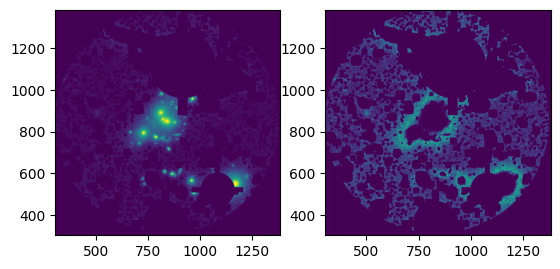

In [8]:
idx = 61

richness = ascii.read('../../data/processed/camira_final.tbl')['Richness']

cutout = np.array(cutouts[str(idx)]['HDU0']['DATA'])
bad_mask = (np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)

# Prepare image
bkg = background_estimate(cutout, mask=bad_mask, z=zs[idx], cosmo=cosmo)
img = cutout - bkg
np.seterr(invalid='ignore', divide='ignore')
sb_img = counts2sb(img, 0)

# Mask with surface brightness limit
_, _, stddev = sigma_clipped_stats(img, mask=bad_mask)
sb_lim = -2.5 * np.log10(3*stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)

sb_img[sb_img >= sb_lim] = np.nan

# Create threshold mask
threshold = 25 + 10 * np.log10(1 + zs[idx])
mask = sb_img > threshold

# Create final masked image
counts_img = sb2counts(sb_img)

radius = np.min((richness[idx] * 17 - 125, 350))
circ_mask = create_circular_mask(zs[idx], cutout, cosmo, radius_kpc=radius)
member_mask = create_member_mask(cutout, bad_mask, bkg, zs[idx], cosmo, merged, idx)
masked_img = counts_img * ~bad_mask * member_mask * circ_mask

# Calculate ICL
print(np.nansum(masked_img * mask) / np.nansum(masked_img))

# Plot the image with and without mask
plt.subplot(121)
plt.imshow(stretch(img * ~bad_mask * member_mask * circ_mask))
lims = (np.min(np.nonzero(circ_mask)), np.max(np.nonzero(circ_mask)))
plt.xlim(*lims)
plt.ylim(*lims)
plt.subplot(122)
plt.imshow(stretch(img * ~bad_mask * member_mask * circ_mask * mask))
plt.xlim(*lims)
plt.ylim(*lims)
plt.show()

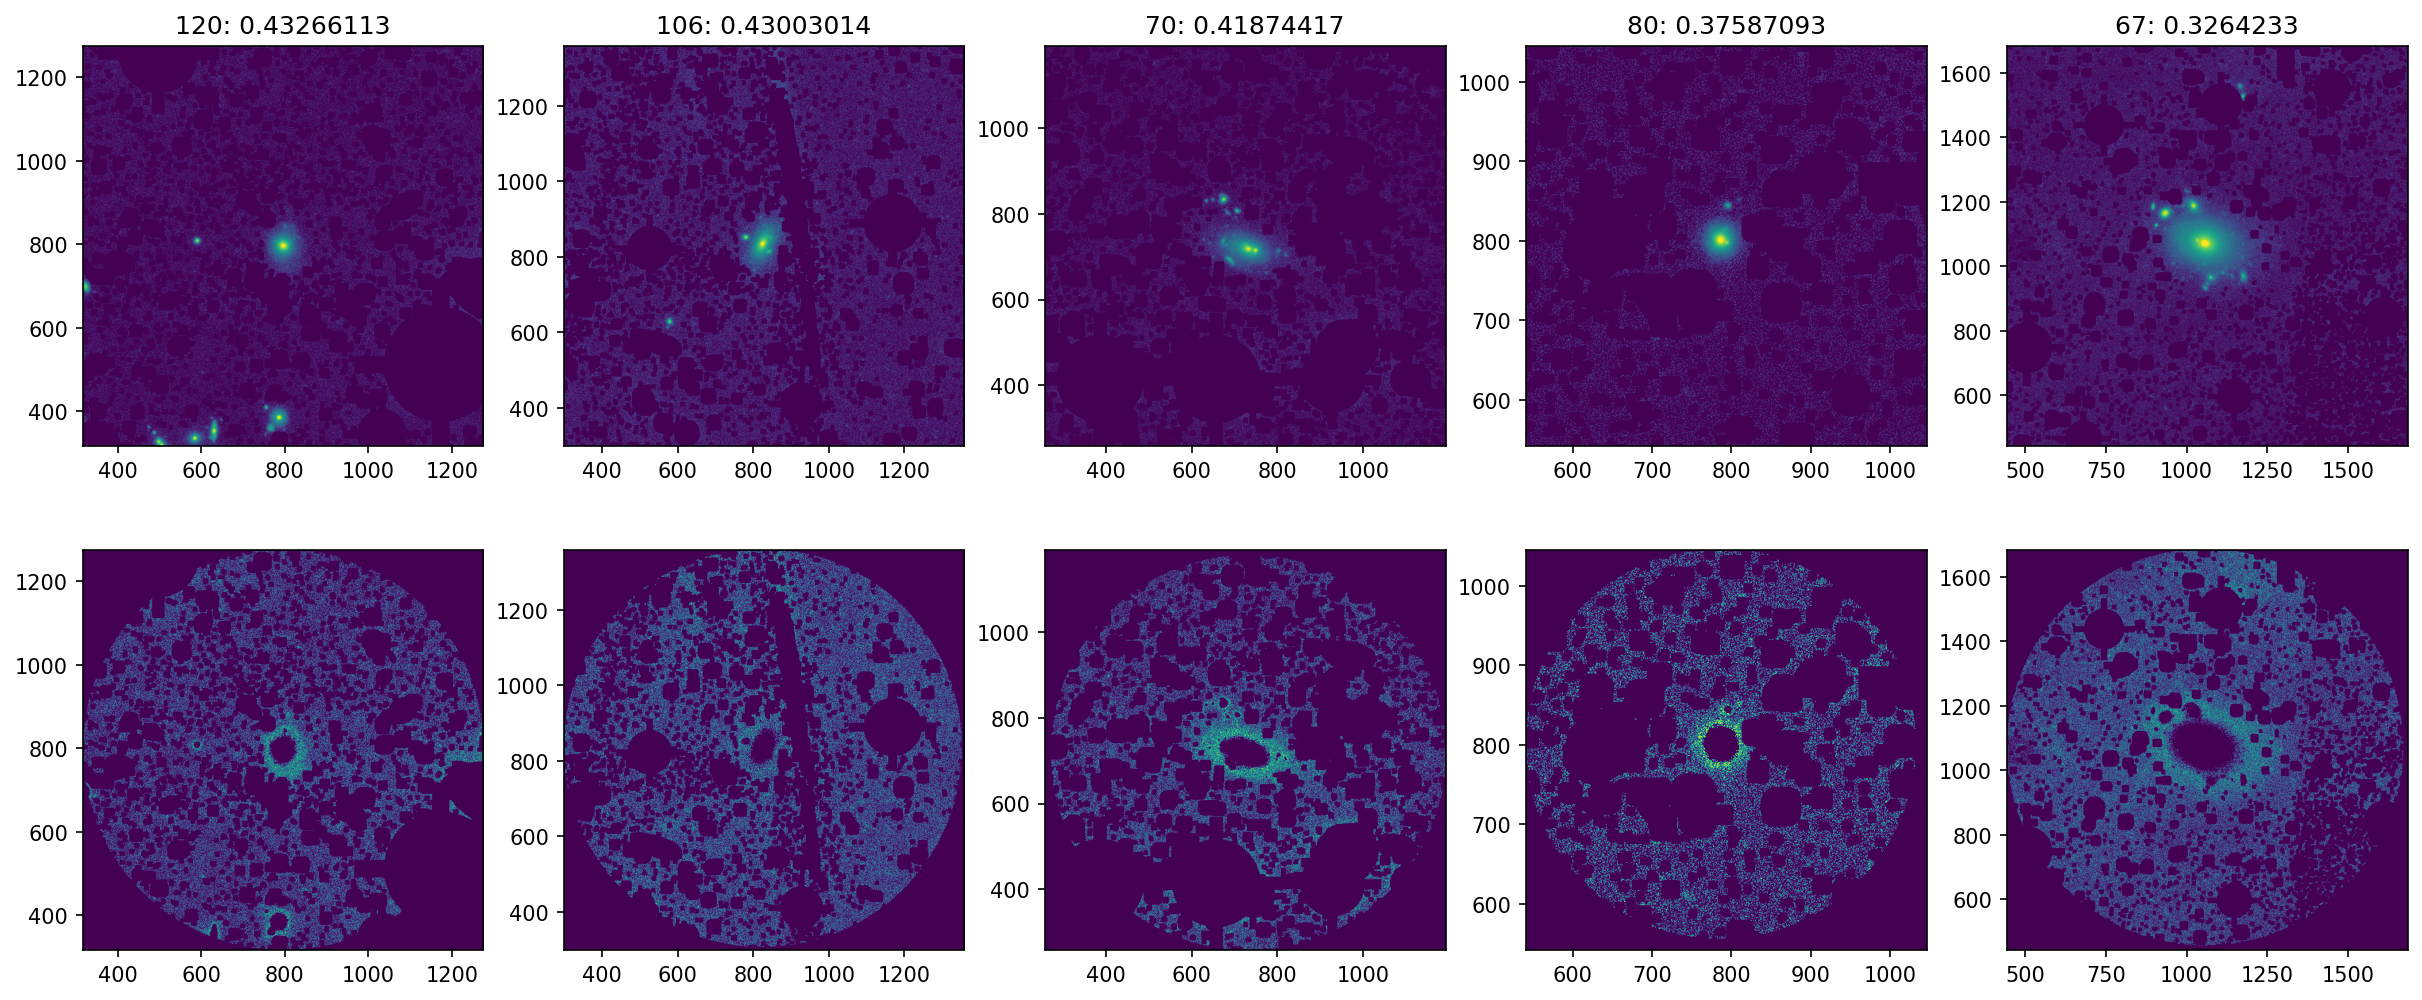

In [9]:
top_5 = [120, 106, 70, 80, 67]
top_5_fracs = [0.43266113, 0.43003014, 0.41874417, 0.37587093, 0.32642330]
bottom_5 = [33, 24, 20, 40, 9]
bottom_5_fracs = [0.03977578, 0.04556135, 0.05114714, 0.06758568, 0.07164083]

richness = ascii.read('../../data/processed/camira_final.tbl')['Richness'][:125]

import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.simplefilter('ignore', category=AstropyWarning)

plt.figure(figsize=(20,8), dpi=150)
for i, idx in enumerate(top_5):
    cutout = np.array(cutouts[str(idx)]['HDU0']['DATA'])
    bad_mask = (np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)

    bkg = background_estimate(cutout, mask=bad_mask, z=zs[idx], cosmo=cosmo)

    member_mask = create_member_mask(cutout, bad_mask, bkg, zs[idx], cosmo, merged, idx)
    radius = np.min((richness[idx] * 17 - 125, 350))
    circ_mask = create_circular_mask(zs[idx], cutout, cosmo, radius_kpc=radius)

    sb_img = counts2sb(cutout - bkg, 0)
    threshold = 25 + 10 * np.log10(1 + zs[idx])
    mask = sb_img > threshold

    plt.subplot(2, 5, i+1)
    plt.imshow(stretch(cutout) * ~bad_mask * member_mask)
    lims = (np.min(np.nonzero(circ_mask)), np.max(np.nonzero(circ_mask)))
    plt.xlim(*lims)
    plt.ylim(*lims)
    plt.title(f'{idx}: {top_5_fracs[i]}')

    plt.subplot(2, 5, i+1+5)
    plt.imshow(stretch(cutout) * ~bad_mask * member_mask * circ_mask * mask)
    lims = (np.min(np.nonzero(circ_mask)), np.max(np.nonzero(circ_mask)))
    plt.xlim(*lims)
    plt.ylim(*lims)
plt.show()

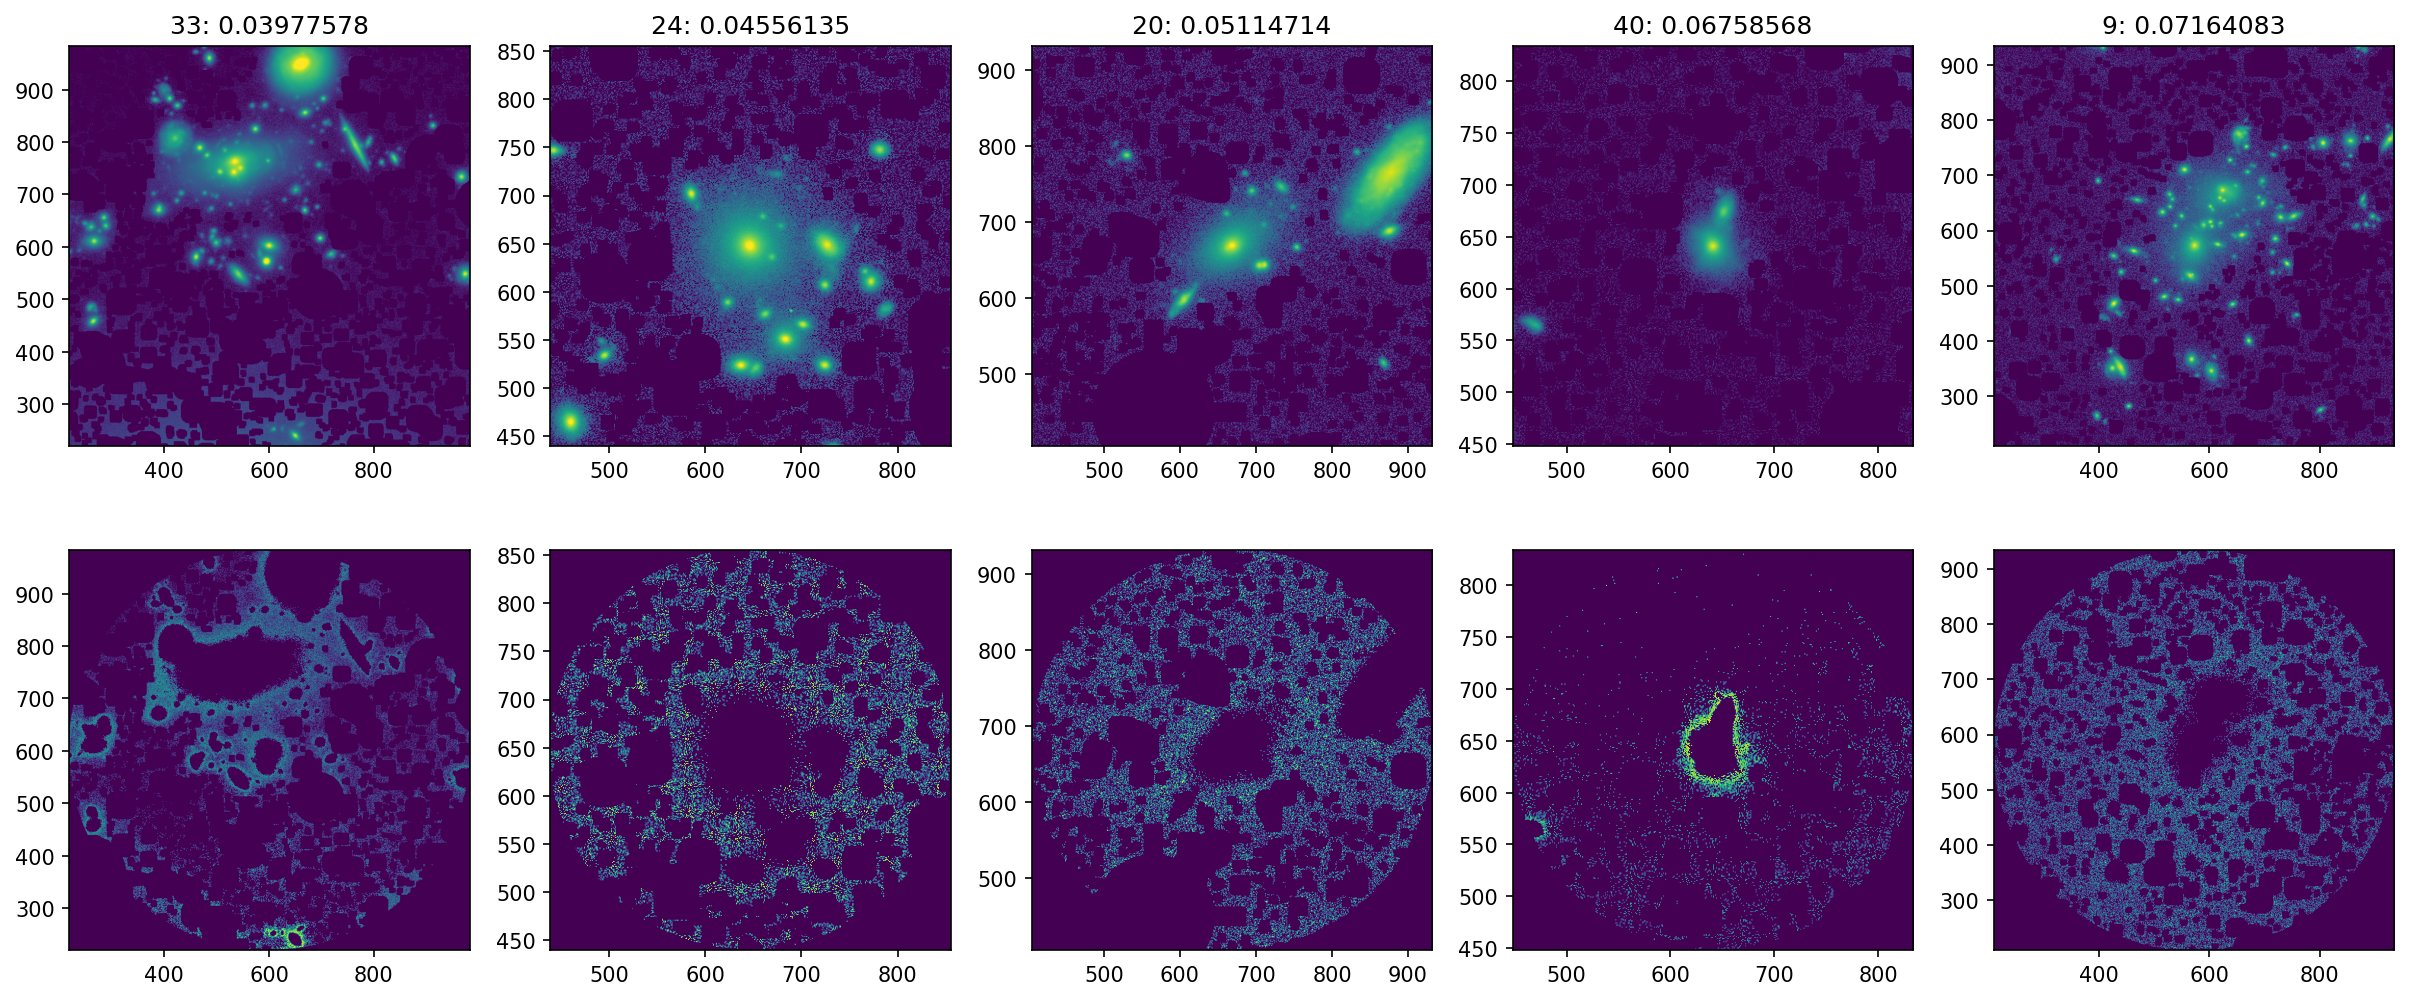

In [10]:
plt.figure(figsize=(20,8), dpi=150)
for i, idx in enumerate(bottom_5):
    cutout = np.array(cutouts[str(idx)]['HDU0']['DATA'])
    bad_mask = (np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)

    bkg = background_estimate(cutout, mask=bad_mask, z=zs[idx], cosmo=cosmo)

    member_mask = create_member_mask(cutout, bad_mask, bkg, zs[idx], cosmo, merged, idx)
    radius = np.min((richness[idx] * 17 - 125, 350))
    circ_mask = create_circular_mask(zs[idx], cutout, cosmo, radius_kpc=radius)

    sb_img = counts2sb(cutout - bkg, 0)
    threshold = 25 + 10 * np.log10(1 + zs[idx])
    mask = sb_img > threshold

    plt.subplot(2, 5, i+1)
    plt.imshow(stretch(cutout) * ~bad_mask * member_mask)
    lims = (np.min(np.nonzero(circ_mask)), np.max(np.nonzero(circ_mask)))
    plt.xlim(*lims)
    plt.ylim(*lims)
    plt.title(f'{idx}: {bottom_5_fracs[i]}')

    plt.subplot(2, 5, i+1+5)
    plt.imshow(stretch(cutout) * ~bad_mask * member_mask * circ_mask * mask)
    lims = (np.min(np.nonzero(circ_mask)), np.max(np.nonzero(circ_mask)))
    plt.xlim(*lims)
    plt.ylim(*lims)
plt.show()

In [11]:
fracs[2][[18, 17, 14, 39, 45, 73]]

array([0.21790508, 0.16075263, 0.16277826, 0.16002085, 0.1347486 ,
       0.09645999])

Try varying the size of the circular mask with the apparent size of the BCG

In [58]:
from scipy import spatial

idx = 0

# Get up to the segmentation step
cutout = np.array(cutouts[str(idx)]['HDU0']['DATA'])
mask_data = np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int)
bad_mask = (mask_data & (1 | 512)).astype(bool)

bkg = background_estimate(cutout, mask=bad_mask, z=zs[idx], cosmo=cosmo)

labels = create_cold_labels(cutout, bad_mask, bkg)

# Get the BCG's label
mid = (cutout.shape[0] // 2, cutout.shape[1] // 2)
bcg_label = labels[mid[0], mid[1]]

[778 891] [531 485]


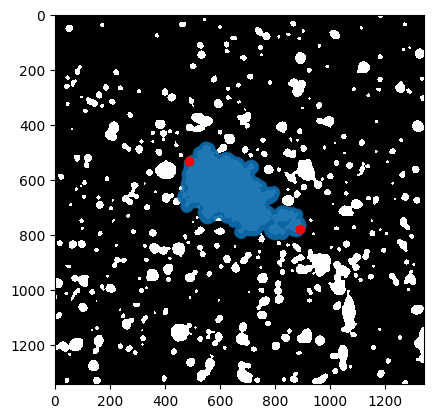

In [59]:
# Coordinates of points that are part of the BCG
pts = np.array(np.argwhere(labels == bcg_label))

# Find points that are furthest apart
candidates = pts[spatial.ConvexHull(pts).vertices]
dist_mat = spatial.distance_matrix(candidates, candidates)
i, j = np.unravel_index(dist_mat.argmax(), dist_mat.shape)
print(candidates[i], candidates[j])

plt.imshow(labels.astype(bool), cmap='gray', interpolation='none')
plt.scatter(*pts.T[::-1], alpha=0.05)
plt.scatter([candidates[i][1], candidates[j][1]], [candidates[i][0], candidates[j][0]], c='red')
plt.show()

In [60]:
pt1 = candidates[i]
pt2 = candidates[j]

distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
distance

475.2315225234959

0.20015741347140967


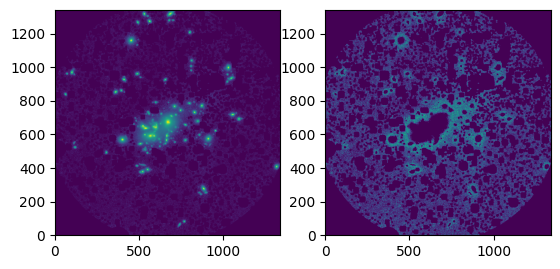

In [61]:
# Prepare image
img = cutout - bkg
np.seterr(invalid='ignore', divide='ignore')
sb_img = counts2sb(img, 0)

# Mask with surface brightness limit
_, _, stddev = sigma_clipped_stats(img, mask=bad_mask)
sb_lim = -2.5 * np.log10(3*stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)

sb_img[sb_img >= sb_lim] = np.nan

# Create threshold mask
threshold = 25 + 10 * np.log10(1 + zs[idx])
mask = sb_img > threshold

# Create final masked image
counts_img = sb2counts(sb_img)

radius = distance * 1.5
# Generate the mask
centre = (img.shape[1] // 2, img.shape[0] // 2)
Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
dist_from_centre = np.sqrt((X-centre[0])**2 + (Y-centre[1])**2)
circ_mask = dist_from_centre <= radius
member_mask = create_member_mask(cutout, bad_mask, bkg, zs[idx], cosmo, merged, idx)
masked_img = counts_img * ~bad_mask * member_mask * circ_mask

# Calculate ICL
print(np.nansum(masked_img * mask) / np.nansum(masked_img))

# Plot the image with and without mask
plt.subplot(121)
plt.imshow(stretch(img * ~bad_mask * member_mask * circ_mask))
lims = (np.min(np.nonzero(circ_mask)), np.max(np.nonzero(circ_mask)))
plt.xlim(*lims)
plt.ylim(*lims)
plt.subplot(122)
plt.imshow(stretch(img * ~bad_mask * member_mask * circ_mask * mask))
plt.xlim(*lims)
plt.ylim(*lims)
plt.show()